# Almaty NO₂ (2019–2025): Hybrid Forecast + Meteo Covariates + Grid Hotspots
Бұл ноутбук:
- Sentinel-5P NO₂ айлық орташа мәні (OFFL → NRTI fallback)
- ERA5-Land айлық метео covariates (t2m, wind10, precipitation, pressure)
- Hybrid модель: SARIMAX(+exog) + ML residual
- Белгісіздік: conformal 90% интервал
- Backtest: rolling-origin
- Spatial анализ: grid hotspot (ең жиі жоғары ұяшықтар, тұрақтылық, low-wind картасы)


In [1]:
# 0) Install (optional, once)
!pip install -q earthengine-api pandas numpy matplotlib scikit-learn statsmodels xgboost geopandas shapely

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import ee
from typing import Optional

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Grid plotting deps
import geopandas as gpd
from shapely.geometry import shape


In [2]:
# 1) Earth Engine init
PROJECT_ID = "continual-modem-484404-n8"  # <-- өз PROJECT_ID-ыңды қой

try:
    ee.Initialize(project=PROJECT_ID)
except Exception:
    ee.Authenticate()
    ee.Initialize(project=PROJECT_ID)

print("✅ Earth Engine connected:", PROJECT_ID)


✅ Earth Engine connected: continual-modem-484404-n8


In [3]:
# 2) Алматы әкімшілік полигонын табу (GAUL) — robust discovery
def find_country_name_gaul(level_fc, contains="kaz"):
    hist = level_fc.aggregate_histogram("ADM0_NAME").getInfo()
    keys = [k for k in hist.keys() if contains.lower() in k.lower()]
    return keys

def find_almaty_candidates(level2_fc, country_name):
    kz = level2_fc.filter(ee.Filter.eq("ADM0_NAME", country_name))
    hist = kz.aggregate_histogram("ADM2_NAME").getInfo()
    cands = [k for k in hist.keys() if "alm" in k.lower()]
    return cands

level2 = ee.FeatureCollection("FAO/GAUL/2015/level2")
kaz_keys = find_country_name_gaul(level2, "kaz")
print("✅ ADM0 keys containing 'kaz':", kaz_keys)

if len(kaz_keys) == 0:
    raise ValueError("GAUL level2 ішінде Kazakhstan табылмады (ADM0_NAME).")

COUNTRY_NAME = kaz_keys[0]
alm_candidates = find_almaty_candidates(level2, COUNTRY_NAME)
print("✅ ADM2 keys containing 'alm':", alm_candidates[:30], "| total:", len(alm_candidates))

if len(alm_candidates) == 0:
    # fallback level1
    level1 = ee.FeatureCollection("FAO/GAUL/2015/level1")
    kaz_keys1 = find_country_name_gaul(level1, "kaz")
    if len(kaz_keys1) == 0:
        raise ValueError("GAUL level1 ішінде Kazakhstan табылмады (ADM0_NAME).")

    COUNTRY_NAME_1 = kaz_keys1[0]
    kz1 = level1.filter(ee.Filter.eq("ADM0_NAME", COUNTRY_NAME_1))
    hist1 = kz1.aggregate_histogram("ADM1_NAME").getInfo()
    alm1 = [k for k in hist1.keys() if "alm" in k.lower()]
    print("✅ Level1 'alm' candidates:", alm1)

    if len(alm1) == 0:
        raise ValueError("GAUL level1 ішінде де 'alm' табылмады. Басқа геометрия керек болуы мүмкін.")

    ALMATY_NAME = alm1[0]
    almaty_fc = (level1
                 .filter(ee.Filter.eq("ADM0_NAME", COUNTRY_NAME_1))
                 .filter(ee.Filter.eq("ADM1_NAME", ALMATY_NAME)))
    print("Using level1:", ALMATY_NAME, "| found:", almaty_fc.size().getInfo())
else:
    ALMATY_NAME = alm_candidates[0]
    almaty_fc = (level2
                 .filter(ee.Filter.eq("ADM0_NAME", COUNTRY_NAME))
                 .filter(ee.Filter.eq("ADM2_NAME", ALMATY_NAME)))
    print("Using level2:", ALMATY_NAME, "| found:", almaty_fc.size().getInfo())

if almaty_fc.size().getInfo() < 1:
    raise ValueError("Алматы полигоны табылмады. ALMATY_NAME-ды alm_candidates ішінен нақты таңдаңыз.")

geometry = almaty_fc.geometry()
print("✅ Almaty geometry ready")


✅ ADM0 keys containing 'kaz': ['Kazakhstan']
✅ ADM2 keys containing 'alm': ['Almaty City area'] | total: 1
Using level2: Almaty City area | found: 1
✅ Almaty geometry ready


In [4]:
# 3) Monthly NO2 (OFFL -> NRTI fallback)
BAND_NO2 = "tropospheric_NO2_column_number_density"

def _monthly_mean_value(collection_id: str, band: str, year: int, month: int, geom, scale=1000):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, "month")

    ic = (ee.ImageCollection(collection_id)
          .filterDate(start, end)
          .filterBounds(geom)
          .select(band))

    if ic.size().getInfo() == 0:
        return None

    img = ic.mean()
    val = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=scale,
        maxPixels=1e13
    ).get(band).getInfo()

    return val

def monthly_no2_offl_then_nrti(year: int, month: int, geom, scale=1000):
    v = _monthly_mean_value("COPERNICUS/S5P/OFFL/L3_NO2", BAND_NO2, year, month, geom, scale=scale)
    if v is not None:
        return float(v), "OFFL"
    v = _monthly_mean_value("COPERNICUS/S5P/NRTI/L3_NO2", BAND_NO2, year, month, geom, scale=scale)
    if v is not None:
        return float(v), "NRTI"
    return None, None

def build_monthly_no2_df(geom, start_year=2019, end_year=2025, scale=1000):
    rows = []
    for y in range(start_year, end_year + 1):
        for m in range(1, 13):
            try:
                val, src = monthly_no2_offl_then_nrti(y, m, geom, scale=scale)
                if val is None:
                    continue
                rows.append({"date": pd.Timestamp(y, m, 1), "no2": float(val), "src": src})
            except Exception:
                pass

    df = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    return df

df = build_monthly_no2_df(geometry, 2019, 2025, scale=1000)

print("✅ NO2 rows:", len(df))
display(df.head())
display(df.tail())
print("Sources:\n", df["src"].value_counts())


✅ NO2 rows: 84


,date,no2,src,year,month
0,2019-01-01,0.000233,OFFL,2019,1
1,2019-02-01,0.000255,OFFL,2019,2
2,2019-03-01,0.000181,OFFL,2019,3
3,2019-04-01,0.000123,OFFL,2019,4
4,2019-05-01,0.000093,OFFL,2019,5


,date,no2,src,year,month
79,2025-08-01,0.000119,OFFL,2025,8
80,2025-09-01,0.000142,OFFL,2025,9
81,2025-10-01,0.000204,OFFL,2025,10
82,2025-11-01,0.000296,OFFL,2025,11
83,2025-12-01,0.000267,OFFL,2025,12


Sources:
 OFFL    84
Name: src, dtype: int64


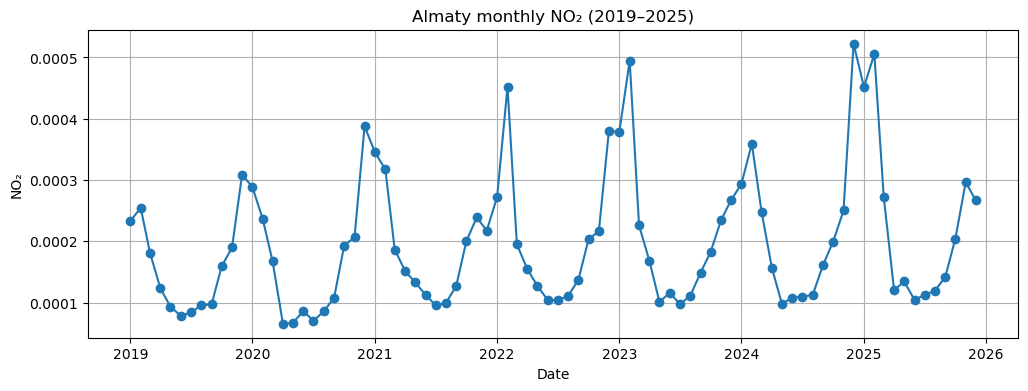

In [5]:
# 4) Plot raw NO2 series
plt.figure(figsize=(12,4))
plt.plot(df["date"], df["no2"], marker="o")
plt.title("Almaty monthly NO₂ (2019–2025)")
plt.xlabel("Date"); plt.ylabel("NO₂")
plt.grid(True)
plt.show()


In [6]:
# 5) METEO covariates (ERA5-Land HOURLY -> monthly)
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")

def build_monthly_meteo_df(geom, start_year=2019, end_year=2025, scale=1000):
    rows = []
    for y in range(start_year, end_year + 1):
        for m in range(1, 13):
            start = ee.Date.fromYMD(y, m, 1)
            end   = start.advance(1, "month")

            ic = (era5.filterDate(start, end)
                      .filterBounds(geom)
                      .select([
                          "temperature_2m",
                          "u_component_of_wind_10m",
                          "v_component_of_wind_10m",
                          "surface_pressure",
                          "total_precipitation"
                      ]))

            if ic.size().getInfo() == 0:
                continue

            mean_img = ic.select([
                "temperature_2m",
                "u_component_of_wind_10m",
                "v_component_of_wind_10m",
                "surface_pressure"
            ]).mean()

            tp_sum = ic.select("total_precipitation").sum()  # meters over month

            u10 = mean_img.select("u_component_of_wind_10m")
            v10 = mean_img.select("v_component_of_wind_10m")
            wind = u10.pow(2).add(v10.pow(2)).sqrt().rename("wind10_ms")
            tC   = mean_img.select("temperature_2m").subtract(273.15).rename("t2m_C")
            sp   = mean_img.select("surface_pressure").rename("sp_Pa")
            tpmm = tp_sum.multiply(1000).rename("tp_mm")

            out = ee.Image.cat([tC, wind, sp, tpmm])

            stats = out.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=scale,
                bestEffort=True,
                maxPixels=1e13
            ).getInfo()

            rows.append({
                "date": pd.Timestamp(y, m, 1),
                "t2m_C": stats.get("t2m_C"),
                "wind10_ms": stats.get("wind10_ms"),
                "sp_Pa": stats.get("sp_Pa"),
                "tp_mm": stats.get("tp_mm"),
            })

    meteo_df = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
    return meteo_df

meteo_df = build_monthly_meteo_df(geometry, 2019, 2025, scale=1000)
print("✅ Meteo rows:", len(meteo_df))
display(meteo_df.head())


✅ Meteo rows: 84


,date,t2m_C,wind10_ms,sp_Pa,tp_mm
0,2019-01-01,-2.870695,1.175315,90005.203821,412.629009
1,2019-02-01,-2.734291,0.914528,89870.998158,512.442161
2,2019-03-01,5.168284,0.706350,89759.420977,589.934394
3,2019-04-01,10.155530,0.247539,89710.077645,2499.445101
4,2019-05-01,13.103660,0.713318,89777.836154,1078.285537


In [7]:
# 6) Merge NO2 + meteo + basic derived flags
df2 = df.merge(meteo_df, on="date", how="left")

df2["heating_season"] = df2["date"].dt.month.isin([11,12,1,2,3]).astype(int)
df2["stagnation"] = 1 / (df2["wind10_ms"] + 0.1)

display(df2.head())


,date,no2,src,year,month,t2m_C,wind10_ms,sp_Pa,tp_mm,heating_season,stagnation
0,2019-01-01,0.000233,OFFL,2019,1,-2.870695,1.175315,90005.203821,412.629009,1,0.784120
1,2019-02-01,0.000255,OFFL,2019,2,-2.734291,0.914528,89870.998158,512.442161,1,0.985680
2,2019-03-01,0.000181,OFFL,2019,3,5.168284,0.706350,89759.420977,589.934394,1,1.240156
3,2019-04-01,0.000123,OFFL,2019,4,10.155530,0.247539,89710.077645,2499.445101,0,2.877378
4,2019-05-01,0.000093,OFFL,2019,5,13.103660,0.713318,89777.836154,1078.285537,0,1.229531


In [8]:
# 7) Feature engineering (NO2 lags/roll + meteo lags)
def make_features(df_in: pd.DataFrame):
    df = df_in.copy().sort_values("date").reset_index(drop=True)

    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["quarter"] = ((df["month"] - 1)//3) + 1
    df["time_idx"] = np.arange(len(df))

    df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

    # NO2 lags / rolling
    for lag in [1,2,3,6,12]:
        df[f"lag_{lag}"] = df["no2"].shift(lag)

    for w in [3,6,12]:
        s = df["no2"].shift(1).rolling(w)
        df[f"roll_mean_{w}"] = s.mean()
        df[f"roll_std_{w}"]  = s.std()

    df["diff_1"]  = df["no2"].diff(1)
    df["diff_12"] = df["no2"].diff(12)

    # Meteo lags (important)
    for col in ["t2m_C","wind10_ms","tp_mm","sp_Pa","stagnation"]:
        if col in df.columns:
            df[f"{col}_lag1"] = df[col].shift(1)
            df[f"{col}_lag2"] = df[col].shift(2)

    df_ml = df.dropna().reset_index(drop=True)

    drop_cols = {"date","no2","src","year","month"}  # keep meteo columns!
    feature_cols = [c for c in df_ml.columns if c not in drop_cols]
    return df_ml, feature_cols

df_ml, feature_cols = make_features(df2)
print("✅ df_ml rows:", len(df_ml), "| features:", len(feature_cols))


✅ df_ml rows: 72 | features: 33


In [9]:
# 8) Hybrid model: SARIMAX(+exog) + ML residual
def build_residual_models():
    models = {
        "Ridge": Ridge(alpha=1.0),
        "GBR": GradientBoostingRegressor(n_estimators=500, random_state=42),
        "RF": RandomForestRegressor(n_estimators=600, max_depth=8, random_state=42),
    }
    if HAS_XGB:
        models["XGB"] = XGBRegressor(
            n_estimators=800,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42
        )
    return models

def fit_sarimax(series: pd.Series, exog: Optional[pd.DataFrame] = None):
    return SARIMAX(
        series,
        exog=exog,
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

# exog columns for SARIMAX (simple, stable)
EXOG_COLS = ["t2m_C","wind10_ms","tp_mm","sp_Pa","heating_season","stagnation"]
EXOG_COLS = [c for c in EXOG_COLS if c in df_ml.columns]

def train_hybrid(df_ml: pd.DataFrame, feature_cols, exog_cols, n_splits=5):
    y = df_ml["no2"].values
    X = df_ml[feature_cols].values

    exog = df_ml[exog_cols] if len(exog_cols) else None
    sar_res = fit_sarimax(df_ml["no2"], exog=exog)

    sar_fit = sar_res.fittedvalues.values
    resid = y - sar_fit

    tscv = TimeSeriesSplit(n_splits=min(n_splits, max(2, len(df_ml)//6)))
    models = build_residual_models()

    best_name, best_mae = None, 1e18
    for name, mdl in models.items():
        maes = []
        for tr, te in tscv.split(X):
            sc = StandardScaler()
            Xtr = sc.fit_transform(X[tr])
            Xte = sc.transform(X[te])

            m = mdl
            m.fit(Xtr, resid[tr])
            pred = m.predict(Xte)
            maes.append(mean_absolute_error(resid[te], pred))

        mae = float(np.mean(maes))
        print(f"{name} residual MAE (CV): {mae:.6f}")
        if mae < best_mae:
            best_mae = mae
            best_name = name

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    resid_model = models[best_name]
    resid_model.fit(Xs, resid)

    print(f"🏆 Best residual model: {best_name} | MAE={best_mae:.6f}")
    return sar_res, resid_model, scaler

sarimax_res, resid_model, scaler = train_hybrid(df_ml, feature_cols, EXOG_COLS, n_splits=5)


C:\Users\Murat\anaconda3\envs\requirements_Murat\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Ridge residual MAE (CV): 0.000080
GBR residual MAE (CV): 0.000046
RF residual MAE (CV): 0.000041
XGB residual MAE (CV): 0.000039
🏆 Best residual model: XGB | MAE=0.000039


In [10]:
# 9) Forecast (recursive features) + Conformal band
def _safe_iloc(series: pd.Series, k: int, default=None):
    if len(series) >= k:
        return float(series.iloc[-k])
    return default

def _recursive_next_row(hist: pd.DataFrame, feature_cols):
    last_date = hist["date"].iloc[-1]
    next_date = last_date + pd.DateOffset(months=1)
    m = int(next_date.month)

    row = {
        "date": next_date,
        "year": int(next_date.year),
        "month": m,
        "quarter": int(((m - 1)//3) + 1),
        "time_idx": int(hist["time_idx"].iloc[-1] + 1),
        "month_sin": float(np.sin(2*np.pi*m/12)),
        "month_cos": float(np.cos(2*np.pi*m/12)),
        "heating_season": int(next_date.month in [11,12,1,2,3]),
    }

    base0 = float(hist["no2"].iloc[0])
    for lag in [1,2,3,6,12]:
        row[f"lag_{lag}"] = _safe_iloc(hist["no2"], lag, default=base0)

    for w in [3,6,12]:
        w_eff = min(w, len(hist))
        tail = hist["no2"].iloc[-w_eff:]
        row[f"roll_mean_{w}"] = float(tail.mean())
        row[f"roll_std_{w}"]  = float(tail.std(ddof=0))

    last = _safe_iloc(hist["no2"], 1, default=base0)
    prev = _safe_iloc(hist["no2"], 2, default=last)
    row["diff_1"] = float(last - prev)

    val_12m_ago = _safe_iloc(hist["no2"], 13, default=None)
    if val_12m_ago is None:
        val_3m_ago = _safe_iloc(hist["no2"], 4, default=last)
        row["diff_12"] = float(last - val_3m_ago)
    else:
        row["diff_12"] = float(last - val_12m_ago)

    # meteo recursive: simplest approach — carry last known values (naive persistence)
    # (Егер қаласаң, метeo-ға бөлек модель қосып, болжап беруге болады.)
    for col in ["t2m_C","wind10_ms","tp_mm","sp_Pa","stagnation"]:
        if col in hist.columns:
            row[col] = float(hist[col].iloc[-1])
            row[f"{col}_lag1"] = float(hist[col].iloc[-1])
            row[f"{col}_lag2"] = float(hist[col].iloc[-2]) if len(hist) > 1 else float(hist[col].iloc[-1])

    X_new = pd.DataFrame([row]).reindex(columns=feature_cols).fillna(0.0)
    return row, X_new

def hybrid_forecast_with_conformal(df_ml: pd.DataFrame, feature_cols,
                                  sarimax_res, resid_model, scaler,
                                  exog_cols,
                                  months=12, alpha=0.1):
    y = df_ml["no2"].values
    sar_fit = sarimax_res.fittedvalues.values
    resid_true = y - sar_fit

    X = df_ml[feature_cols].values
    Xs = scaler.transform(X)
    resid_pred = resid_model.predict(Xs)
    abs_err = np.abs(resid_true - resid_pred)
    q = float(np.quantile(abs_err, 1 - alpha))
    print(f"📏 Conformal radius q={q:.6f} for {(1-alpha)*100:.0f}% interval")

    # SARIMAX future needs exog future too; we'll reuse last-known exog (persistence)
    if len(exog_cols):
        last_exog = df_ml[exog_cols].iloc[-1:].values
        exog_future = np.repeat(last_exog, repeats=months, axis=0)
    else:
        exog_future = None

    sar_future = sarimax_res.get_forecast(steps=months, exog=exog_future).predicted_mean.values

    hist = df_ml.copy()
    rows = []
    for i in range(months):
        row, X_new = _recursive_next_row(hist, feature_cols)
        Xn = scaler.transform(X_new.values)

        r_hat = float(resid_model.predict(Xn)[0])
        pred = float(sar_future[i] + r_hat)

        row["no2"] = pred
        row["lower"] = pred - q
        row["upper"] = pred + q

        rows.append(row)
        hist = pd.concat([hist, pd.DataFrame([row])], ignore_index=True)

    return pd.DataFrame(rows)

forecast_df = hybrid_forecast_with_conformal(
    df_ml=df_ml,
    feature_cols=feature_cols,
    sarimax_res=sarimax_res,
    resid_model=resid_model,
    scaler=scaler,
    exog_cols=EXOG_COLS,
    months=12,
    alpha=0.1
)

forecast_table = forecast_df[["date","no2","lower","upper"]].copy()
forecast_table[["no2","lower","upper"]] = forecast_table[["no2","lower","upper"]].round(6)
display(forecast_table)


📏 Conformal radius q=0.000101 for 90% interval


,date,no2,lower,upper
0,2026-01-01,0.000296,0.000195,0.000397
1,2026-02-01,0.000376,0.000275,0.000477
2,2026-03-01,0.000318,0.000218,0.000419
3,2026-04-01,0.000298,0.000197,0.000398
4,2026-05-01,0.000277,0.000176,0.000377
5,2026-06-01,0.000310,0.000210,0.000411
6,2026-07-01,0.000335,0.000234,0.000436
7,2026-08-01,0.000341,0.000241,0.000442
8,2026-09-01,0.000319,0.000219,0.000420
9,2026-10-01,0.000329,0.000229,0.000430


In [11]:
# 10) Backtest (rolling-origin) with SARIMAX exog + recursive features
def mape(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100)

def backtest_hybrid(df_ml, feature_cols, exog_cols, resid_model, n_splits=5, horizon=3, min_train_len=13):
    X_all = df_ml[feature_cols].values
    tscv = TimeSeriesSplit(n_splits=min(n_splits, max(2, len(df_ml)//horizon)))

    fold_metrics = []
    all_preds = []

    for fold, (tr, te) in enumerate(tscv.split(X_all), start=1):
        te = te[:horizon]
        if len(te) < 1:
            continue

        train_df = df_ml.iloc[tr].copy().reset_index(drop=True)
        test_df  = df_ml.iloc[te].copy().reset_index(drop=True)

        if len(train_df) < min_train_len:
            continue

        exog_train = train_df[exog_cols] if len(exog_cols) else None
        sar_train = fit_sarimax(train_df["no2"], exog=exog_train)

        y_tr = train_df["no2"].values
        sar_fit_tr = sar_train.fittedvalues.values
        resid_tr = y_tr - sar_fit_tr

        X_tr = train_df[feature_cols].values
        sc = StandardScaler()
        X_tr_s = sc.fit_transform(X_tr)

        mdl = resid_model.__class__(**resid_model.get_params())
        mdl.fit(X_tr_s, resid_tr)

        # exog_future: use persistence from last train row
        if len(exog_cols):
            last_exog = train_df[exog_cols].iloc[-1:].values
            exog_future = np.repeat(last_exog, repeats=len(te), axis=0)
        else:
            exog_future = None

        sar_future = sar_train.get_forecast(steps=len(te), exog=exog_future).predicted_mean.values

        hist = train_df.copy()
        preds = []
        for i in range(len(te)):
            row, X_new = _recursive_next_row(hist, feature_cols)
            X_new_s = sc.transform(X_new.values)
            r_hat = float(mdl.predict(X_new_s)[0])
            y_hat = float(sar_future[i] + r_hat)
            preds.append(y_hat)

            row["no2"] = y_hat
            hist = pd.concat([hist, pd.DataFrame([row])], ignore_index=True)

        y_true = test_df["no2"].values
        y_pred = np.array(preds)

        fold_metrics.append({
            "fold": fold,
            "start_test": str(test_df["date"].min().date()),
            "end_test": str(test_df["date"].max().date()),
            "horizon": len(te),
            "MAE": float(mean_absolute_error(y_true, y_pred)),
            "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
            "MAPE_%": float(mape(y_true, y_pred)),
            "R2": float(r2_score(y_true, y_pred)) if len(te) > 1 else np.nan
        })

        for d, yt, yp in zip(test_df["date"].values, y_true, y_pred):
            all_preds.append({"date": pd.Timestamp(d), "y_true": float(yt), "y_pred": float(yp), "fold": fold})

    metrics_df = pd.DataFrame(fold_metrics)
    preds_df = pd.DataFrame(all_preds).sort_values("date").reset_index(drop=True)
    return metrics_df, preds_df

metrics_df, preds_df = backtest_hybrid(df_ml, feature_cols, EXOG_COLS, resid_model, n_splits=5, horizon=3, min_train_len=13)

display(metrics_df.round(6))


C:\Users\Murat\anaconda3\envs\requirements_Murat\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Murat\anaconda3\envs\requirements_Murat\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Murat\anaconda3\envs\requirements_Murat\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


,fold,start_test,end_test,horizon,MAE,RMSE,MAPE_%,R2
0,2,2022-01-01,2022-03-01,3,0.004625,0.006993,1155.586466,-4216.586348
1,3,2023-01-01,2023-03-01,3,0.000138,0.000184,37.807430,-1.796415
2,4,2024-01-01,2024-03-01,3,0.000060,0.000076,19.077003,-1.760161
3,5,2025-01-01,2025-03-01,3,0.000080,0.000086,21.986868,0.248278


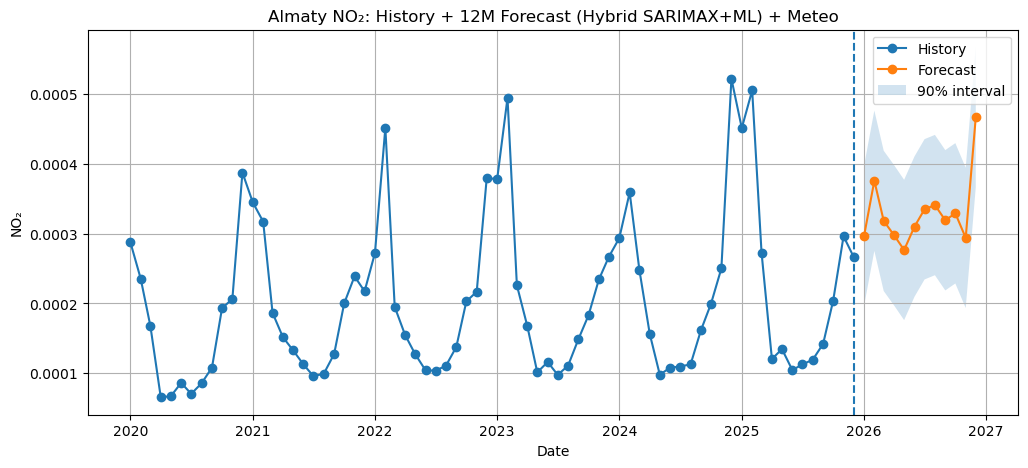

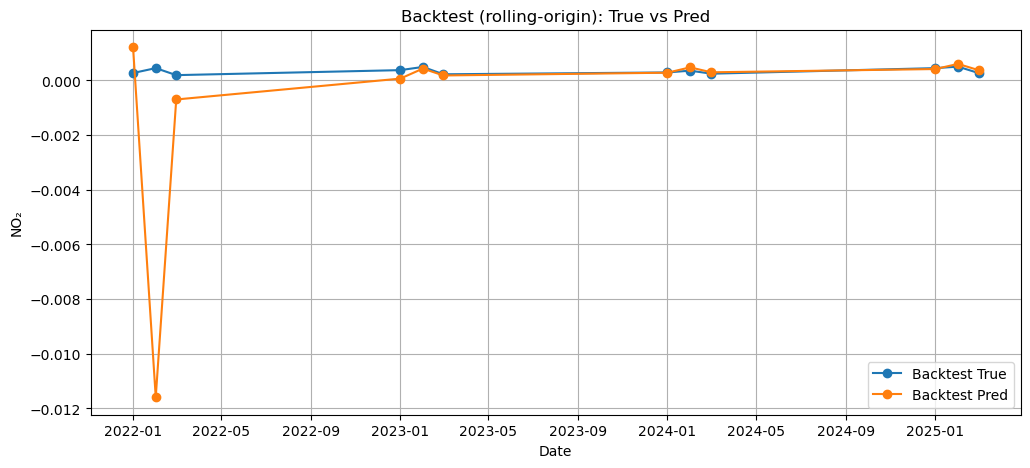

In [12]:
# 11) Plots
plt.figure(figsize=(12,5))
plt.plot(df_ml["date"], df_ml["no2"], label="History", marker="o")
plt.plot(forecast_df["date"], forecast_df["no2"], label="Forecast", marker="o")
plt.fill_between(forecast_df["date"], forecast_df["lower"], forecast_df["upper"], alpha=0.2, label="90% interval")
plt.axvline(df_ml["date"].max(), linestyle="--")
plt.title("Almaty NO₂: History + 12M Forecast (Hybrid SARIMAX+ML) + Meteo")
plt.xlabel("Date"); plt.ylabel("NO₂")
plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(preds_df["date"], preds_df["y_true"], label="Backtest True", marker="o")
plt.plot(preds_df["date"], preds_df["y_pred"], label="Backtest Pred", marker="o")
plt.title("Backtest (rolling-origin): True vs Pred")
plt.xlabel("Date"); plt.ylabel("NO₂")
plt.grid(True); plt.legend()
plt.show()


## Spatial analysis: Grid hotspot maps


In [14]:
# 12) Grid creation
import math

def make_grid_fc(region, cell_km=2.0):
    # bounds-ты клиентке аламыз
    b = region.bounds().getInfo()
    coords = b["coordinates"][0]
    lons = [c[0] for c in coords]
    lats = [c[1] for c in coords]
    lon_min, lon_max = min(lons), max(lons)
    lat_min, lat_max = min(lats), max(lats)

    lat0 = 0.5 * (lat_min + lat_max)
    dlat = (cell_km * 1000) / 111320.0
    dlon = (cell_km * 1000) / (111320.0 * math.cos(math.radians(lat0)))

    feats = []
    gid = 0
    lat = lat_min
    while lat < lat_max:
        lon = lon_min
        while lon < lon_max:
            # ✅ proj-ты анық string қылып береміз
            rect = ee.Geometry.Rectangle(
                [lon, lat, lon + dlon, lat + dlat],
                proj="EPSG:4326",
                geodesic=False
            )

            # ✅ region-мен қиылыссын (proj да string)
            rect = rect.intersection(region, maxError=1)

            feats.append(ee.Feature(rect, {"gid": gid}))
            gid += 1
            lon += dlon
        lat += dlat

    return ee.FeatureCollection(feats)

grid_fc = make_grid_fc(geometry, cell_km=2.0)
print("Grid cells:", grid_fc.size().getInfo())


Grid cells: 150


In [15]:
# 13) Monthly NO2 image for grid (OFFL -> NRTI)
def monthly_no2_image(year, month, geom):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, "month")

    def mean_img(collection_id):
        ic = (ee.ImageCollection(collection_id)
              .filterDate(start, end)
              .filterBounds(geom)
              .select(BAND_NO2))
        return ee.Image(ee.Algorithms.If(ic.size().gt(0), ic.mean(), None))

    img = mean_img("COPERNICUS/S5P/OFFL/L3_NO2")
    img = ee.Image(ee.Algorithms.If(img, img, mean_img("COPERNICUS/S5P/NRTI/L3_NO2")))
    return img

def grid_month_fc(year, month, geom, grid_fc, scale=1000):
    img = monthly_no2_image(year, month, geom)
    fc = ee.FeatureCollection(ee.Algorithms.If(
        img,
        ee.Image(img).reduceRegions(grid_fc, ee.Reducer.mean(), scale),
        ee.FeatureCollection([])
    ))
    return fc.map(lambda f: f.set({"date": ee.Date.fromYMD(year, month, 1).format("YYYY-MM-01")}))


In [16]:
# 14) Collect grid for all months (WARNING: can be slow)
def collect_grid_all_months(start_year=2019, end_year=2025, scale=1000):
    all_rows = []
    for y in range(start_year, end_year + 1):
        for m in range(1, 13):
            print(f"Grid NO2: {y}-{m:02d}")
            fc = grid_month_fc(y, m, geometry, grid_fc, scale=scale)
            feats = fc.getInfo().get("features", [])
            if len(feats) == 0:
                continue
            for f in feats:
                p = f["properties"]
                all_rows.append({
                    "date": p.get("date"),
                    "gid": p.get("gid"),
                    "no2": p.get("mean")
                })
    out = pd.DataFrame(all_rows)
    out["date"] = pd.to_datetime(out["date"])
    return out.sort_values(["date","gid"]).reset_index(drop=True)

grid_all = collect_grid_all_months(2019, 2025, scale=1000)
print(grid_all.shape)
display(grid_all.head())


Grid NO2: 2019-01
Grid NO2: 2019-02
Grid NO2: 2019-03
Grid NO2: 2019-04
Grid NO2: 2019-05
Grid NO2: 2019-06
Grid NO2: 2019-07
Grid NO2: 2019-08
Grid NO2: 2019-09
Grid NO2: 2019-10
Grid NO2: 2019-11
Grid NO2: 2019-12
Grid NO2: 2020-01
Grid NO2: 2020-02
Grid NO2: 2020-03
Grid NO2: 2020-04
Grid NO2: 2020-05
Grid NO2: 2020-06
Grid NO2: 2020-07
Grid NO2: 2020-08
Grid NO2: 2020-09
Grid NO2: 2020-10
Grid NO2: 2020-11
Grid NO2: 2020-12
Grid NO2: 2021-01
Grid NO2: 2021-02
Grid NO2: 2021-03
Grid NO2: 2021-04
Grid NO2: 2021-05
Grid NO2: 2021-06
Grid NO2: 2021-07
Grid NO2: 2021-08
Grid NO2: 2021-09
Grid NO2: 2021-10
Grid NO2: 2021-11
Grid NO2: 2021-12
Grid NO2: 2022-01
Grid NO2: 2022-02
Grid NO2: 2022-03
Grid NO2: 2022-04
Grid NO2: 2022-05
Grid NO2: 2022-06
Grid NO2: 2022-07
Grid NO2: 2022-08
Grid NO2: 2022-09
Grid NO2: 2022-10
Grid NO2: 2022-11
Grid NO2: 2022-12
Grid NO2: 2023-01
Grid NO2: 2023-02
Grid NO2: 2023-03
Grid NO2: 2023-04
Grid NO2: 2023-05
Grid NO2: 2023-06
Grid NO2: 2023-07
Grid NO2: 

,date,gid,no2
0,2019-01-01,0,NaN
1,2019-01-01,1,0.000245
2,2019-01-01,2,0.000243
3,2019-01-01,3,0.000257
4,2019-01-01,4,0.000270


,gid,hot_freq
23,33,0.666667
15,22,0.646341
16,23,0.621951
22,32,0.567901
31,43,0.543210
14,21,0.469880
17,24,0.463415
24,34,0.456790
8,13,0.433735
32,44,0.419753


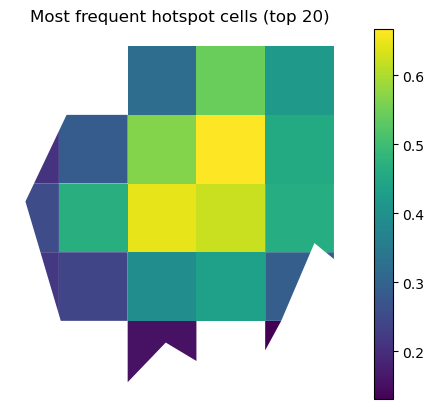

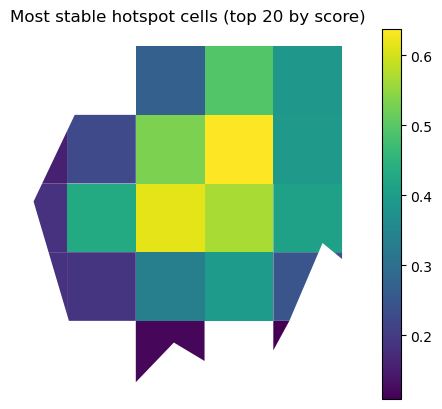

Hotspot rate by low_wind_month (0=normal,1=low wind):


,low_wind_month,hot_rate
0,0,0.104601
1,1,0.104167


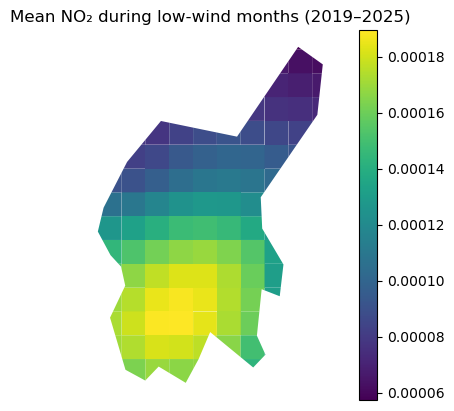

In [19]:
# 15) Hotspot frequency (top 10% per month) + stability + low-wind map
def hotspot_frequency(grid_all, q=0.90):
    df = grid_all.dropna(subset=["no2"]).copy()
    thr = df.groupby("date")["no2"].quantile(q).rename("thr").reset_index()
    df = df.merge(thr, on="date", how="left")
    df["hot"] = (df["no2"] >= df["thr"]).astype(int)

    freq = (df.groupby("gid")["hot"]
              .mean()
              .rename("hot_freq")
              .reset_index()
              .sort_values("hot_freq", ascending=False))
    return df, freq

grid_all_flagged, hot_freq = hotspot_frequency(grid_all, q=0.90)
display(hot_freq.head(10))

# Most frequent hotspots map (top 20)
top = hot_freq.head(20)[["gid","hot_freq"]]
top_gdf = grid_geom.merge(top, on="gid", how="inner")
ax = top_gdf.plot(column="hot_freq", legend=True)
ax.set_title("Most frequent hotspot cells (top 20)")
ax.set_axis_off()
plt.show()

# Yearly stability
tmp = grid_all_flagged.copy()
tmp["year"] = tmp["date"].dt.year
yearly_freq = (tmp.groupby(["year","gid"])["hot"]
                 .mean()
                 .rename("hot_freq_year")
                 .reset_index())

stability = (yearly_freq.groupby("gid")["hot_freq_year"]
               .agg(["mean","std","min","max","count"])
               .reset_index())
stability["score"] = stability["mean"] - 0.5*stability["std"]
stable_top = stability.sort_values("score", ascending=False).head(20)[["gid","score"]]

stable_gdf = grid_geom.merge(stable_top, on="gid", how="inner")
ax = stable_gdf.plot(column="score", legend=True)
ax.set_title("Most stable hotspot cells (top 20 by score)")
ax.set_axis_off()
plt.show()

# Low-wind months analysis (needs meteo in df2)
met = df2[["date","wind10_ms"]].copy()
grid_m = grid_all_flagged.merge(met, on="date", how="left")
wind_thr = grid_m["wind10_ms"].quantile(0.25)
grid_m["low_wind_month"] = (grid_m["wind10_ms"] <= wind_thr).astype(int)

summary = (grid_m.groupby("low_wind_month")["hot"]
             .mean()
             .rename("hot_rate")
             .reset_index())
print("Hotspot rate by low_wind_month (0=normal,1=low wind):")
display(summary)

lowwind_mean = (grid_m[grid_m["low_wind_month"]==1]
                .groupby("gid")["no2"].mean()
                .rename("no2_lowwind_mean")
                .reset_index())

lw_gdf = grid_geom.merge(lowwind_mean, on="gid", how="left")
ax = lw_gdf.plot(column="no2_lowwind_mean", legend=True)
ax.set_title("Mean NO₂ during low-wind months (2019–2025)")
ax.set_axis_off()
plt.show()


In [20]:
# 16) Save outputs
df2.to_csv("almaty_no2_meteo_2019_2025.csv", index=False)
df_ml.to_csv("almaty_no2_ml_ready_with_meteo.csv", index=False)
forecast_table.to_csv("forecast_table_12m_with_meteo.csv", index=False)
metrics_df.to_csv("backtest_metrics_with_meteo.csv", index=False)
preds_df.to_csv("backtest_predictions_with_meteo.csv", index=False)
grid_all.to_csv("almaty_no2_grid_all_months.csv", index=False)
hot_freq.to_csv("almaty_no2_hotspot_frequency.csv", index=False)

joblib.dump(resid_model, "residual_model.pkl")
joblib.dump(scaler, "residual_scaler.pkl")
joblib.dump(sarimax_res, "sarimax_model.pkl")

print("✅ Saved: csv + pkl")


✅ Saved: csv + pkl


In [18]:
# ============================================================
# Convert EE grid -> GeoPandas GeoDataFrame
# ============================================================
import geopandas as gpd
from shapely.geometry import shape

grid_json = grid_fc.getInfo()["features"]

grid_geom = gpd.GeoDataFrame(
    [{
        "gid": f["properties"]["gid"],
        "geometry": shape(f["geometry"])
    } for f in grid_json],
    crs="EPSG:4326"
)

print(grid_geom.head())

   gid                                           geometry
0    0                                   MULTIPOINT EMPTY
1    1  POLYGON ((76.84588 43.16958, 76.84588 43.18563...
2    2  POLYGON ((76.87057 43.17513, 76.87057 43.18563...
3    3  POLYGON ((76.89525 43.17790, 76.89525 43.18563...
4    4  POLYGON ((76.90101 43.18563, 76.89525 43.18563...
